In [366]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV, LassoCV
import scipy
import math
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn import linear_model

import sys
# import mss
sys.path.append('../')
from mss import visreader as mvis
from mss import mssmain as msm
from mss import align
from mss import dm
from sklearn.metrics import jaccard_score
from scipy.stats import entropy
from scipy import spatial
from scipy.spatial import distance

In [161]:
df = pd.read_csv('../example_data/clustering/testdata_1114_patternrec.csv')

In [162]:
df = df[(df['Average RT (min)'] >= 2) & (df['Average RT (min)'] <=18)].copy()
df.reset_index(inplace=True,drop=True)

In [164]:
source_col = df.columns[df.columns.str.contains('dil-to')]
dfp = df[source_col].copy()
dfp.shape

(5134, 36)

In [165]:
mean_list = []
for i in list(set([i[:-2] for i in df.iloc[:,5:].columns])):
    mean_list.append(list(df.iloc[:,5:][df.iloc[:,5:].columns[df.iloc[:,5:].columns.str.contains(i)]].mean(1)))

In [166]:
df_m = pd.DataFrame(mean_list).T
df_m.columns = list(set([i[:-2] for i in df.iloc[:,5:].columns]))
df_m.head()

,20181114_RuralCreek,20181114_SR520-Cal-in-DI_1000mL_dil-to-1mL,20181114_SR518-Cal_1000mL_dil-to-10mL,20181114_SwanCreek-May,20181114_MSMS_Miller-Creek-20181025_Site5down-HLB,20181114_SR520-Cal-in-DI_1mL,20181114_SR518-Cal_1000mL_dil-to-160mL,20181114_SR520-Creek_Mix6A,20181114_SR520-Creek_Mix4A,20181114_SR520-Cal-in-DI_25mL,...,20181114_Crescent-Creek-Jan,20181114_SR518-Cal_1000mL_dil-to-60mL,20181114_SR518-Cal_1000mL_dil-to-25mL,20181114_SR518-Cal_1000mL,20181114_MSMS_Miller-Creek-20181025_Site4-HLB,20181114_SR520-Cal-in-DI_1000mL_dil-to-400mL,20181114_SR520-Creek_Mix5B,20181114_SR520-Cal-in-DI_1000mL,20181114_SR520-Creek_Mix3,20181114_SR520-Cal-in-DI_400mL
0,2674.666667,346.666667,1652.000000,2784.000000,74715.0,2727.333333,24321.333333,4308.0,11058.666667,9069.000000,...,3622.666667,11792.333333,4968.333333,24611.380952,14036.0,57931.333333,11472.333333,27219.904762,16504.333333,51588.333333
1,1013.333333,1029.666667,1098.666667,1781.000000,146454.0,1429.333333,5090.666667,2074.0,4189.666667,2038.333333,...,2011.333333,3319.000000,2471.666667,17034.761905,153779.0,16742.000000,2608.666667,10014.333333,6482.666667,15910.000000
2,1866.000000,1970.666667,2764.666667,1968.666667,175420.0,1685.666667,29622.333333,2768.0,5127.333333,3245.666667,...,3860.666667,11075.000000,4827.333333,35953.666667,147749.0,39520.333333,11360.333333,20995.619048,6701.000000,36139.000000
3,625.333333,2679.000000,3221.333333,500.666667,87411.0,2901.000000,39947.000000,5701.0,97944.000000,84524.666667,...,581.333333,18243.000000,8532.333333,49141.809524,40774.0,710576.333333,34094.666667,358528.095238,192073.333333,873611.000000
4,183.000000,0.000000,191.666667,267.000000,34312.0,169.000000,7213.333333,241.0,1895.000000,1292.000000,...,0.000000,3149.000000,657.000000,6482.238095,0.0,21355.333333,2153.000000,9811.190476,4040.333333,11485.000000


In [167]:
mean_list = []
for i in list(set([i[:-2] for i in source_col])):
    mean_list.append(list(dfp[dfp.columns[dfp.columns.str.contains(i)]].mean(1)))

In [168]:
df_mean = pd.DataFrame(mean_list).T
df_mean.columns = list(set([i[:-2] for i in source_col]))
d_clu = df_mean[df_mean.columns[df_mean.columns.str.contains('520')]].copy()

In [169]:
c_data = d_clu.values
c_norm = [((row-np.mean(row))/np.std(row)) for row in c_data]
#Clean up dataframe
c_norm = np.asarray(c_norm)
d_norm = pd.DataFrame(c_norm)
d_norm['index']=d_clu.index
d_norm.set_index('index',inplace=True)
d_norm.dropna(how='all',inplace=True)
d_norm.columns = d_clu.columns

D:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



eps selected 2.311585892094129


array([0.        , 0.        , 0.        , ..., 2.92846687, 2.95941942,
       3.03145393])

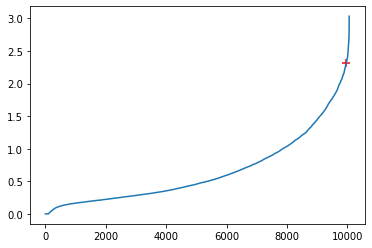

In [149]:
dm.eps_assess(d_norm, 26)

In [150]:
d_norm.columns

Index(['SR520_Cal_in_DI_1000mL_dil_to_10mL', 'SR520_Cal_in_DI_160mL',
       'SR520_Cal_in_DI_1000mL', 'SR520_Cal_in_DI_10mL',
       'SR520_Cal_in_DI_1000mL_dil_to_160mL', 'SR520_Cal_in_DI_60mL',
       'SR520_Cal_in_DI_1000mL_dil_to_400mL',
       'SR520_Cal_in_DI_1000mL_dil_to_25mL',
       'SR520_Cal_in_DI_1000mL_dil_to_60mL',
       'SR520_Cal_in_DI_1000mL_dil_to_1mL', 'SR520_Cal_in_DI_25mL',
       'SR520_Cal_in_DI_1mL', 'SR520_Cal_in_DI_400mL'],
      dtype='object')

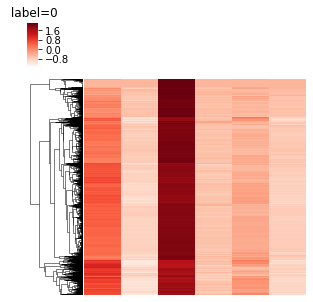

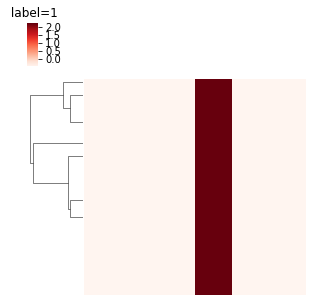

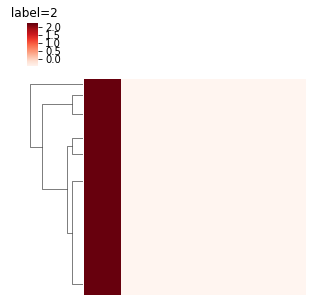

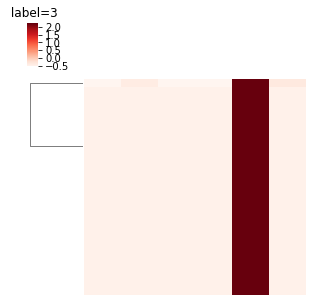

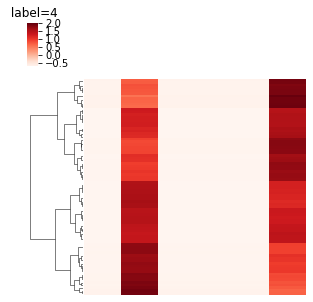

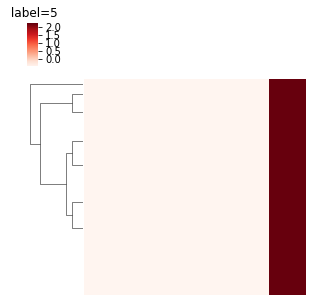

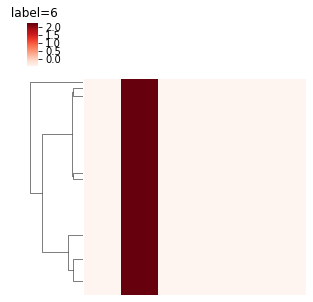

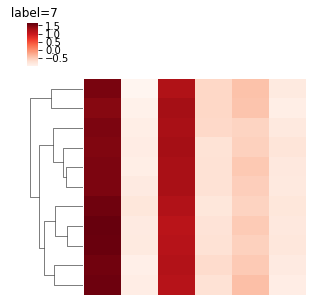

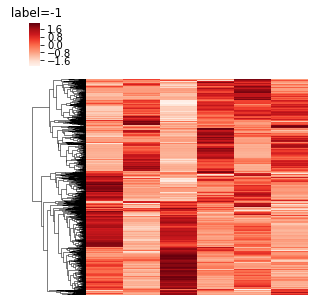

In [170]:
dbscan = cluster.DBSCAN(eps=0.2, min_samples=13).fit(d_norm)
labels = dbscan.labels_
unique_labels = set(dbscan.labels_)

for i,k in enumerate(unique_labels):
    indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
    sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=False,yticklabels=False,xticklabels=False,figsize=(5,5))
    plt.title(' label='+ str(k))
    plt.show()
    
d_init = d_clu.copy()
d_label = d_clu.loc[d_norm.index] #Use the index to match back to the original datasheet
d_label.insert(len(d_clu.columns),"label", dbscan.labels_.tolist())

In [171]:
d_source = df.loc[d_label[d_label['label'] == 0].index].copy()
d_bg = df.loc[d_label[d_label['label'] != 0].index].copy()

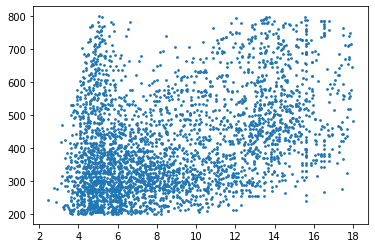

In [133]:
plt.scatter(d_source['Average RT (min)'], d_source['Average m/z'],s=3)
#plt.scatter(d_bg['Average RT (min)'], d_bg['Average m/z'],s=3,alpha=0.5)

In [134]:
df_m.columns[df_m.columns.str.contains('Creek')]

Index(['20181114_RuralCreek', '20181114_SwanCreek-May',
       '20181114_MSMS_Miller-Creek-20181025_Site5down-HLB',
       '20181114_SR520-Creek_Mix6A', '20181114_SR520-Creek_Mix4A',
       '20181114_SwanCreek-Dec', '20181114_SR520-Creek_Mix6B',
       '20181114_MSMS_Miller-Creek-20181025_Site8MW-HLB',
       '20181114_SR520-Creek_Mix5A', '20181114_SR520-Creek_Mix1',
       '20181114_CoulterCreek', '20181114_SR520-Creek_Mix2',
       '20181114_SR520-Creek_Mix4B', '20181114_Crescent-Creek-May',
       '20181114_Crescent-Creek-Jan',
       '20181114_MSMS_Miller-Creek-20181025_Site4-HLB',
       '20181114_SR520-Creek_Mix5B', '20181114_SR520-Creek_Mix3'],
      dtype='object')

In [112]:
#select comparison sample
source_col = '20181114_SR520-Cal-in-DI_400mL'
sample_col ='20181114_RuralCreek'

d_index = df_m.index[df_m[sample_col] >= 2000] #Threshold?
source_index = d_source.index
simp_score = len([i for i in source_index if i in d_index])/len(source_index)
print('simple source prediction score: ', simp_score)

#MSDIAL algorithm, if 2d only consider mz/rt, 3d (plus intensity) need to alter their equations
#Maybe not accurate
union_index = list(set(source_index).union(set(d_index)))
intersec_index = [i for i in source_index if i in d_index]

sl = df_m[source_col]
samplel = df_m[sample_col]
union_b = np.asarray(df_m.iloc[union_index,0])
intersec_b = np.asarray(df_m.iloc[intersec_index,0])
union_s = np.asarray([sl[i] for i in union_index])
intersec_s = np.asarray([sl[i] for i in intersec_index])
#Normalize?
dot_score = ((np.dot(union_b,union_s)
 /(np.linalg.norm(union_b)
   *np.linalg.norm(union_s)))
/(np.dot(intersec_b,intersec_s)
  /(np.linalg.norm(intersec_b)
    *np.linalg.norm(intersec_s))))
print('dot product score:', dot_score)

#Jaccard score can only be used on label
#log transformed situation
a = list(map(lambda x: 1 if x == 0 else x, sl))
logsl = [int(round((np.log(i)))) for i in a]
b = list(map(lambda x: 1 if x == 0 else x, samplel))
logsamplel = [int(round((np.log(i)))) for i in b]
j_score_raw = jaccard_score(logsl,logsamplel,average='weighted')
print('Jaccard score(raw):', j_score_raw) #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

#Binary transformed situation
binsl = list(map(lambda x: 1 if x > 0 else x, sl))
binsamplel = list(map(lambda x: 1 if x > 0 else x, samplel))
j_score_bin = jaccard_score(binsl,binsamplel,average='binary')
print('Jaccard score(binary):',j_score_bin)

#KL divergence
from scipy.stats import entropy
print('raw data entropy', entropy(sl, samplel))
print('log data entropy', entropy(logsl, logsamplel))
scores = [simp_score, dot_score, j_score_raw,
          j_score_bin, entropy(sl, samplel),
          entropy(logsl, logsamplel)]

KeyError: '20181114_RuralCreek'

In [172]:
def similarity_score(source_col, sample_col,dataframe, threshold=2000):
    df_m = dataframe.copy()
    d_index = df_m.index[df_m[sample_col] >= threshold] #Threshold?
    source_index = d_source.index
    simp_score = len([i for i in source_index if i in d_index])/len(source_index)

    union_index = list(set(source_index).union(set(d_index)))
    intersec_index = [i for i in source_index if i in d_index]

    sl = df_m[source_col]
    samplel = df_m[sample_col]
    union_b = np.asarray(df_m.iloc[union_index,0])
    intersec_b = np.asarray(df_m.iloc[intersec_index,0])
    union_s = np.asarray([sl[i] for i in union_index])
    intersec_s = np.asarray([sl[i] for i in intersec_index])
    #Normalize?
    dot_score = ((np.dot(union_b,union_s)
     /(np.linalg.norm(union_b)
       *np.linalg.norm(union_s)))
    /(np.dot(intersec_b,intersec_s)
      /(np.linalg.norm(intersec_b)
        *np.linalg.norm(intersec_s))))

    #Jaccard score can only be used on label
    #log transformed situation
    a = list(map(lambda x: 1 if x == 0 else x, sl))
    logsl = [int(round((np.log(i)))) for i in a]
    b = list(map(lambda x: 1 if x == 0 else x, samplel))
    logsamplel = [int(round((np.log(i)))) for i in b]
    j_score_raw = jaccard_score(logsl,logsamplel,average='weighted')

    #Binary transformed situation
    binsl = list(map(lambda x: 1 if x > 0 else x, sl))
    binsamplel = list(map(lambda x: 1 if x > 0 else x, samplel))
    j_score_bin = jaccard_score(binsl,binsamplel,average='binary')

    #KL divergence
    from scipy.stats import entropy
    scores = [simp_score, dot_score, j_score_raw,
              j_score_bin, entropy(sl, samplel),
              entropy(logsl, logsamplel)]
    return scores

In [173]:
df_m.columns[df_m.columns.str.contains('520')]

Index(['20181114_SR520-Cal-in-DI_1000mL_dil-to-1mL',
       '20181114_SR520-Cal-in-DI_1mL', '20181114_SR520-Creek_Mix6A',
       '20181114_SR520-Creek_Mix4A', '20181114_SR520-Cal-in-DI_25mL',
       '20181114_SR520-Creek_Mix6B',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-60mL',
       '20181114_SR520-Creek_Mix5A',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-160mL',
       '20181114_SR520-Cal-in-DI_60mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-10mL',
       '20181114_SR520-Creek_Mix1', '20181114_SR520-Cal-in-DI_160mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-25mL',
       '20181114_SR520-Creek_Mix2', '20181114_SR520-Creek_Mix4B',
       '20181114_SR520-Cal-in-DI_10mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-400mL',
       '20181114_SR520-Creek_Mix5B', '20181114_SR520-Cal-in-DI_1000mL',
       '20181114_SR520-Creek_Mix3', '20181114_SR520-Cal-in-DI_400mL'],
      dtype='object')

In [194]:
df[['Average RT (min)','Average m/z','20181114_SR520-Cal-in-DI_400mL_1','20181114_SR520-Creek_Mix5A_1']]

,Average RT (min),Average m/z,20181114_SR520-Cal-in-DI_400mL_1,20181114_SR520-Creek_Mix5A_1
0,5.696,200.07405,52611,6210
1,4.326,200.12823,20188,3940
2,4.220,200.12869,31573,3972
3,5.920,200.16484,928752,24297
4,5.295,200.20181,12580,410
...,...,...,...,...
5129,15.569,795.62750,0,0
5130,5.228,796.45288,5185,174
5131,13.722,796.54181,9702,3052
5132,5.058,798.47003,15683,476


In [175]:
similarity_score('SR520_Cal_in_DI_400mL', 'SR520_Cal_in_DI_400mL', df_m)

[0.9282916541126845, 0.9984753975961559, 1.0, 1.0, 0.0, 0.0]

In [156]:
score_list = []
for i in df_m.columns[df_m.columns.str.contains('Creek')]:
    score_list.append(similarity_score('SR520_Cal_in_DI_400mL', i, df_m))
df_score = pd.DataFrame(score_list)
df_score.columns = ['Simple score', 'dot product', 'jaccard_raw', 'jaccard_bin', 'entropy_raw', 'entropy_log']
df_score.index = df_m.columns[df_m.columns.str.contains('Creek')]

In [157]:
df_score.to_csv('../dev/dummydata/0815scores2.csv')

In [365]:
# Alignment assessment?
#1. find closest neighbour for each mz/RT
#2. calc entropy?

def dist_euclidean(elem1, elem2):
    t_sum=0
    for i in range(len(elem1)):
        for j in range(len(elem1[0])):
            t_sum+= np.square(elem1[i][j]-elem2[i][j])
    return np.sqrt(t_sum)

def dist_cosine(elem1, elem2):
    temp1=[]
    temp2=[]
    for i in range(len(elem1)):
        temp1.extend(elem1[i])
        temp2.extend(elem2[i])
    return distance.cosine(temp1, temp2)

from scipy.stats import entropy
def dist_KL_row_avg(elem1, elem2):
    Y=[]
    for i in range(len(elem1)):
        Y.append(entropy(elem1[i], elem2[i]))
    return np.average(Y)

In [353]:
a = np.array([[200.9,300.5],[0,1]])
b = np.array([[200.8553,300.4319],[0,1]])
# The smaller the better
print('euclidean dist:', dist_euclidean(a,b))
print('cos similarity:', dist_cosine(a, b))
print('KL divergence avg:', dist_KL_row_avg(a, b))

euclidean dist: 0.08145980603955932
cos similarity: 2.0101698083863084e-12
KL divergence avg: 1.021268757516956e-12


In [367]:
#Next: using dummy data to assess the alignment score system
import pickle
with open('./dummydata/sourcepair.data', 'rb') as filehandle:
    # read the data as binary data stream
    source = pickle.load(filehandle)

In [368]:
with open('./dummydata/randsource_missing_pattern.data', 'rb') as f:
    # read the data as binary data stream
    source_miss = pickle.load(f)

In [396]:
data=[]
for i_s,j in enumerate(source):
    zipsource = list(zip(j[0],j[1]))
    for i_miss in np.arange(i_s * 5,(i_s + 1) * 5):
        zipmiss = list(zip(source_miss[i_miss][0], source_miss[i_miss][1]))
        source_pair = []
        miss_pair = []
        for i in zipmiss:
            _,index = spatial.KDTree(zipsource).query(i)
            #if abs(i[0] - zipsource[index][0]) <= 200*5e-6 and abs(i[1] - zipsource[index][1]) < 0.2:
            source_pair.append(zipsource[index])
            miss_pair.append(i)
        data.append([i_s, dist_euclidean(source_pair,miss_pair),
               dist_cosine(source_pair,miss_pair),
               dist_KL_row_avg(source_pair,miss_pair),
               len(miss_pair)/200])
#         print('euclidean dist:', dist_euclidean(source_pair,miss_pair))
#         print('cos similarity:', dist_cosine(source_pair,miss_pair))
#         print('KL divergence avg:', dist_KL_row_avg(source_pair,miss_pair))
#         print('total match:', len(miss_pair)/200)
dfilter=pd.DataFrame(data)
dfilter.columns = ['source #', 'euclidean dist', 'cos score', 'KL divergence', 'simple match']

In [397]:
dfilter.to_csv('./dummydata/d_wofilter_alignmentassessment.csv')